# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
Целевой признак

    Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder
import lightgbm

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Процент пропущенных значений в каждом столбце.

In [5]:
(1 - df.count() / len(df)) * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Столбец 'DateCreated' дублирует дату в признаке 'DateCrawled'. 'NumberOfPictures', 'PostalCode' и 'RegistrationMonth'  мало информативны для дальнейшего анализа. Удалим эти признаки.

In [8]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth'], axis=1)

Выделим отдельно численные и категориальные признаки.

In [9]:
num_features  = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
cat_features  = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

Посмотрим на зависимость числовых признаков друг от друга.

In [10]:
# sns.pairplot(df)

In [11]:
df[df['Price'] ==0]['Price'].count()

10772

Объявления с нулевой ценой лучше убрать из анализа.

In [12]:
df = df[df['Price'] !=0]
df[df['Price'] ==0]['Price'].count()

0

<AxesSubplot:>

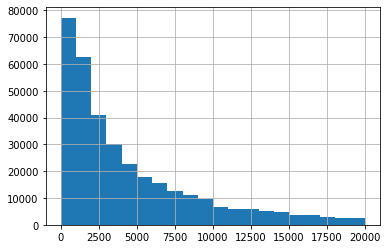

In [13]:
df['Price'].hist(bins=20)

В некоторых категориальных переменных большой процент пропущенных значений, заполним их пока что значением 'unknown'.

In [14]:
df[cat_features] = df[cat_features].fillna('unknown')
(1 - df[cat_features].count() / len(df)) * 100

VehicleType    0.0
Gearbox        0.0
Model          0.0
FuelType       0.0
NotRepaired    0.0
Brand          0.0
dtype: float64

In [16]:
len(df[df['RegistrationYear'] <= 1800])

53

In [17]:
df = df[df['RegistrationYear'] > 1800]

In [18]:
df = df[df['RegistrationYear'] <= 2016]

<AxesSubplot:>

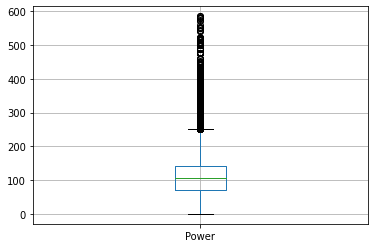

In [19]:
df[df['Power']< 600].boxplot('Power')

In [20]:
len(df[df['Power'] > 600])

330

In [21]:
df.loc[(df['Power'] > 600) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median')).copy()
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64').copy()

In [22]:
len(df[df['Price'] < 100])

2440

In [23]:
df = df[df['Price'] > 100]

<AxesSubplot:>

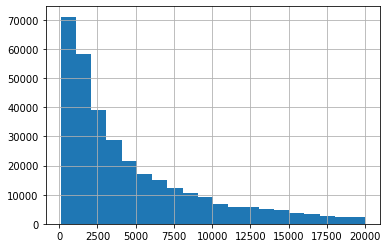

In [24]:
df['Price'].hist(bins=20)

Применяю Label encoding для кодирования категориальных признаков.

In [26]:
cat_futures = list(df.select_dtypes(include='object').columns)
le = LabelEncoder()
for i in cat_futures:
    le.fit(df[i].astype('str'))
    df[i] = le.transform(df[i].astype('str'))
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,480,7,1993,1,101,116,150000,6,38,1,93,163404
1,18300,2,2011,1,190,227,125000,2,1,2,93,162926
2,9800,6,2004,0,163,117,125000,2,14,1,83,147677
3,1500,5,2001,1,75,116,150000,6,38,0,86,41002
4,3600,5,2008,1,69,101,90000,2,31,0,100,156533


###  Выводы

- Данные были успешно загружены и проанализированы. 
- Отобраны признаки, необходимые для построения моделей.
- Пропущенные значения в категориальных признаках заполнены значением "unknown".
- Удалены нулевые значения в столбце "Price".
- Категориальные признаки закодированы с помощью "Label encoding".

## Обучение моделей

### Разделяем выборки

In [27]:
X = df.drop('Price', axis=1)
y = df['Price']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=12345
)

In [29]:
X_train.shape

(244732, 11)

In [30]:
y_train.shape

(244732,)

In [31]:
X_test.shape

(81578, 11)

In [32]:
y_test.shape

(81578,)

Проведём масштабирование признаков к стандартному нормальному распределению с помощью метода StandardScaler

In [33]:
ss = StandardScaler()
ss.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(ss.transform(X_train), columns = columns)
X_test = pd.DataFrame(ss.transform(X_test), columns = columns)

### Константная модель

Создадим константную модель и посчитаем для нее значение RMSE.

In [34]:
model_base = pd.Series(
    data=y.mean(),
    index=y.index 
)

rmse_base = mean_squared_error(y, model_base) ** 0.5

print('RMSE стандартной модели: ', rmse_base)

RMSE стандартной модели:  4545.868052752003


### Линейная регрессия

In [35]:
%%time

model_line = LinearRegression()

model_line.fit(X_train, y_train)

CPU times: user 130 ms, sys: 95.9 ms, total: 226 ms
Wall time: 226 ms


LinearRegression()

In [48]:
rmse_line = cross_val_score(model_line, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print('RMSE модели линейной регрессии ',(-rmse_line.mean()))

RMSE модели линейной регрессии  2922.2987767119675


In [49]:
%%time

predict_line = model_line.predict(X_test)

CPU times: user 25.2 ms, sys: 26.9 ms, total: 52.1 ms
Wall time: 10.5 ms


### Градиентный бустинг

In [38]:
param_model = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}

In [39]:
lgbm = lightgbm.LGBMRegressor(random_state=12345)

model_LGBM = GridSearchCV(
    estimator=lgbm,
    param_grid=param_model,    
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

model_LGBM.fit(X_train, y_train)

model_LGBM.best_params_

{'learning_rate': 0.3, 'max_depth': 5}

In [40]:
print('RMSE модели LightGBM на обучающей выборке: ', (-model_LGBM.best_score_))

RMSE модели LightGBM на обучающей выборке:  1643.7522503228374


In [41]:
%%time

model_LGBM = lightgbm.LGBMRegressor(learning_rate=0.3, max_depth=5, random_state=12345)

model_LGBM.fit(X_train, y_train)

CPU times: user 45.9 s, sys: 363 ms, total: 46.2 s
Wall time: 46.5 s


LGBMRegressor(learning_rate=0.3, max_depth=5, random_state=12345)

In [50]:
%%time

predict_LGBM = model_LGBM.predict(X_test)

CPU times: user 575 ms, sys: 0 ns, total: 575 ms
Wall time: 518 ms


### Случайный лес

In [56]:
tree_params = {'max_depth': [4, 6],
               'min_samples_split': [2, 5]}

In [57]:
forest = RandomForestRegressor(random_state=12345)

model_forest = GridSearchCV(
    estimator=forest,
    param_grid=tree_params,
    n_jobs=-1,
    cv=3,
    scoring='neg_root_mean_squared_error'
) 

model_forest.fit(X_train, y_train)

model_forest.best_params_

{'max_depth': 6, 'min_samples_split': 2}

In [58]:
print('RMSE модели случайного леса на обучающей выборке: ', (-model_forest.best_score_))

RMSE модели случайного леса на обучающей выборке:  2247.4255430549133


In [59]:
%%time

model_forest = RandomForestRegressor(max_depth=6, min_samples_split=2, random_state=12345)

model_forest.fit(X_train, y_train)

CPU times: user 35.1 s, sys: 42.8 ms, total: 35.2 s
Wall time: 35.2 s


RandomForestRegressor(max_depth=6, random_state=12345)

In [60]:
%%time

predict_forest = model_forest.predict(X_test) 

CPU times: user 340 ms, sys: 77 µs, total: 340 ms
Wall time: 346 ms


### Работа лучшей модели на тестовой выборке

In [61]:
%%time

predict_LGBM = model_LGBM.predict(X_test) 

rmse_LGBM = mean_squared_error(y_test, predict_LGBM) ** 0.5

print('RMSE модели LightGBM на тестовой выборке: ', rmse_LGBM)

RMSE модели LightGBM на тестовой выборке:  1645.1934296116349
CPU times: user 537 ms, sys: 7.06 ms, total: 544 ms
Wall time: 507 ms


## Анализ моделей

- Все обученные модели смогли улучшить RMSE базовой модели.
- Метрика RMSE для моделей на тестовой выборке:
    - Base-line: 4545.87
    - LinearModel: 2922.30
    - LightGBM: 1643.75
    - RandomForestRegressor: 2247.43
- Время обучения для моделей:
    - LinearModel: 226ms
    - LightGBM: 46,5s
    - RandomForestRegressor: 35.2s
- Время предсказания для моделей:
    - LinearModel: 10.6ms
    - LightGBM: 518ms
    - RandomForestRegressor: 346ms
- Лучший результат показала модель градиентного бустинга при средней скорости обучения относительно других моделей у нее самый низкий показатель RMSE.
    - Значение RMSE на тестовой выборке у модели LightGBM: 1645.19
    - Время предсказания: 507 ms

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей